<a href="https://colab.research.google.com/github/ringerH/NLP/blob/main/Fine_tuning_BERT(multilabel_text_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 30.85 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [2]:
!pip install -Uqr models/official/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.8 MB/s eta 0:0

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv('df2.csv')

In [4]:
df.shape

(44022, 3)

In [5]:
df.head(2)

,text,Unnamed: 1,label_encoded
0,Donald Trump just couldn t wish all Americans ...,NaN,2
1,House Intelligence Committee Chairman Devin Nu...,NaN,2


In [6]:
new2_df = df.drop(columns=['Unnamed: 1'])

In [7]:
new2_df.shape

(44022, 2)

In [10]:
new2_df.head(2)

,text,label_encoded
0,Donald Trump just couldn t wish all Americans ...,2
1,House Intelligence Committee Chairman Devin Nu...,2


<Axes: title={'center': 'Subject distro'}, ylabel='Frequency'>

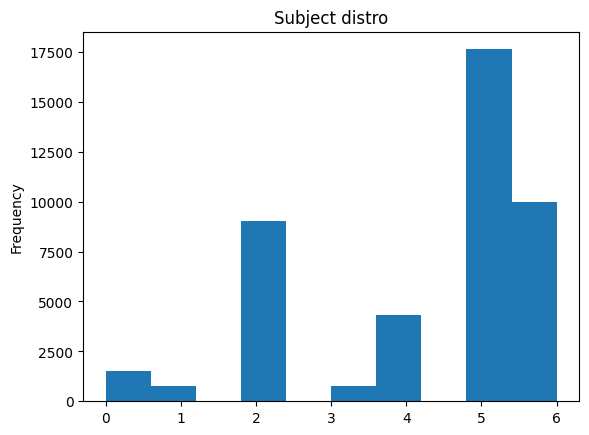

In [11]:
new2_df.label_encoded.plot(kind='hist', title='Subject distro')

In [38]:
train_df, valid_df = train_test_split(new2_df, random_state=42, train_size=0.8, test_size=0.2, stratify=new2_df['label_encoded'])
train_df.shape, valid_df.shape

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


((35217, 2), (8805, 2))

In [39]:
new2_df.head(3)

,text,label_encoded
0,Donald Trump just couldn t wish all Americans ...,2
1,House Intelligence Committee Chairman Devin Nu...,2
2,"On Friday, it was revealed that former Milwauk...",2


**visualizing balanced data**

In [ ]:
import matplotlib.pyplot as plt

train_class_distribution = train_df['label_encoded'].value_counts()
valid_class_distribution = valid_df['label_encoded'].value_counts()

# Sort the indices (class labels) for consistency in plotting
class_labels = sorted(train_class_distribution.index)

# Create subplots for training and validation data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(class_labels, train_class_distribution[class_labels], tick_label=class_labels)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(class_labels, valid_class_distribution[class_labels], tick_label=class_labels)
plt.title('Class Distribution in Validation Data')
plt.xlabel('Class Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


**MOST IMPORTANT STEP**

The tf.data API here helps us build this flexible and efficient input pipeline.
As during training, many input elements need to be pre-processed. We need to convert this to a format of **token IDs, input mask IDs and input type IDs** so that, BERT can accept it as input. Since many input elements will have to be processed, the tf.data offers the **tf.data.Dataset.map transformation, which applies a user defined function to each element of the input data set**.
And because the input elements are independent to one another, the pre-processing step can be parallelised across multiple CPU cores.
To make this possible, **the map transformation from the tf.data API provides an argument where we can specify the level of parallelism that we want during pre-processing.**
So we can do all the pre-processing step on the CPU, and that way there's no CPU or GPU overhead.



**Creating a Python object to attain iterability for usage in loops**

To construct a data set, from data in memory, we use the tf.data.Dataset
from **tensor method or the tf.data.Dataset from tensor slices method** and the return dataset is  a Python object which is iterable, which makes it possible to consume its elements using a for loop.

**ESSENTIALLY**

The dataset needs to be converted to a Python object to attain iterability(for obvious reasons) :)


In [40]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['label_encoded'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['text'].values, valid_df['label_encoded'].values))

**Loop test**

In [41]:
for text, label_encoded in train_data.take(5):
  print(text)
  print(label_encoded)

tf.Tensor(b'WASHINGTON (Reuters) - President Donald Trump is asking Congress to give the Pentagon about $2 billion for a \xe2\x80\x9cflexible\xe2\x80\x9d fund to use against Islamic State over the next six months, as his administration weighs changes to the U.S.-led campaign against the militant group. Trump is also seeking to upgrade long-underfunded facilities at the U.S. military\xe2\x80\x99s Guantanamo Bay detention center in Cuba that Trump\xe2\x80\x99s Democratic predecessor, Barack Obama, unsuccessfully sought to close during his eight-year administration. \xe2\x80\x9cIt doesn\xe2\x80\x99t seem like we are going to close it anytime soon,\xe2\x80\x9d John Roth, the acting Pentagon comptroller, told a Pentagon news briefing, explaining the move.  The proposals were part of a $30 billion supplemental request to Congress to add more money to the Pentagon\xe2\x80\x99s budget during the government\xe2\x80\x99s ongoing fiscal year, which began under the Obama administration and ends in

**DOWNLOAD PRE_TRAINED BERT**

In [43]:
label_list=[0,1,2,3,4,5,6]
max_seq_length = 128
train_batch_size = 32

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable = True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer=tokenization.FullTokenizer(vocab_file, do_lower_case)

Tokenized text **from pre-trained data, NOT our data**

In [44]:
tokenizer.wordpiece_tokenizer.tokenize("ne another,the pre processing ah step can be paralyzed across multipleCPU course.And to make this possible, um, the map transformation")

['ne',
 'another',
 '##,',
 '##the',
 'pre',
 'processing',
 'ah',
 'step',
 'can',
 'be',
 'paralyzed',
 'across',
 '[UNK]',
 '[UNK]',
 'to',
 'make',
 'this',
 'possible',
 '##,',
 'um',
 '##,',
 'the',
 'map',
 'transformation']

Token IDs

In [45]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("ndent of one another,the pre processing ah step can be paralyzed across multipleCPU course.And to make this possible, um, the map transformation"))

[1050,
 16454,
 1997,
 2028,
 2178,
 29623,
 10760,
 3653,
 6364,
 6289,
 3357,
 2064,
 2022,
 22348,
 2408,
 100,
 100,
 2000,
 2191,
 2023,
 2825,
 29623,
 8529,
 29623,
 1996,
 4949,
 8651]

Now we Tokenize **OUR** data, a crucial step is to **pad** the token ids to **match the max_seq_length** which'll eventually be an input for BERT.

**Prepend CLS token at the beginning**

**Append SEP token at the end**

Defining function to convert one row into a feature acceptable to BERT, this function will futher be applied to each row(i mean, ofc) using the **tf.data.Dataset** map, but there's a catch, it can't be done..unless...

In [85]:
def to_feature(text, label_encoded, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a=text.numpy(),
                                             text_b=None,
                                             label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

..we **wrap the function in a TF op** for it to be converted into a desirable data-structure to be consumed by BERT.

In [83]:
def to_feature_map(text, label_encoded):
    input_ids, input_mask, segment_ids = tf.py_function(
        to_feature,
        inp=[text, label_encoded],
        Tout=[tf.int32, tf.int32, tf.int32]
    )
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])

    label_id = tf.one_hot(label_encoded, depth=7, dtype=tf.float32)
    label_id.set_shape([7])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)


In [86]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .shuffle(1000)
                              .batch(32)
                              .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(32)
                              .prefetch(tf.data.experimental.AUTOTUNE))

TypeError: ignored

Train n Validation data specification i.e., how the input data-structure for BERT looks like

In [49]:
train_data.element_spec


({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32, 7), dtype=tf.int32, name=None))

In [50]:
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32, 7), dtype=tf.int32, name=None))

**Now, the model**

Since it's a multi-label classification problem we use **soft-max activation and Categorical Cross entropy loss**

In [51]:
def create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    drop = tf.keras.layers.Dropout(0.4)(pooled_output)
    output = tf.keras.layers.Dense(7, activation='softmax', name='output')(drop)

    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        },
        outputs=output)
    return model

In [52]:
new2_df.head()

,text,label_encoded
0,Donald Trump just couldn t wish all Americans ...,2
1,House Intelligence Committee Chairman Devin Nu...,2
2,"On Friday, it was revealed that former Milwauk...",2
3,"On Christmas day, Donald Trump announced that ...",2
4,Pope Francis used his annual Christmas Day mes...,2


NVM :)

In [74]:
reverted_labels = []

for row in y_true:
    label = None
    for idx, value in enumerate(row):
        if value == 1:
            label = idx
            break
    if label is not None:
        reverted_labels.append(label)

print("Reverted Labels:", reverted_labels)


Reverted Labels: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [76]:
new2_df['label_encoded'] = reverted_labels

In [ ]:
new2_df

In [69]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.F1Score(average='micro', threshold=None, name='f1_score', dtype=None)])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

**The real picture**

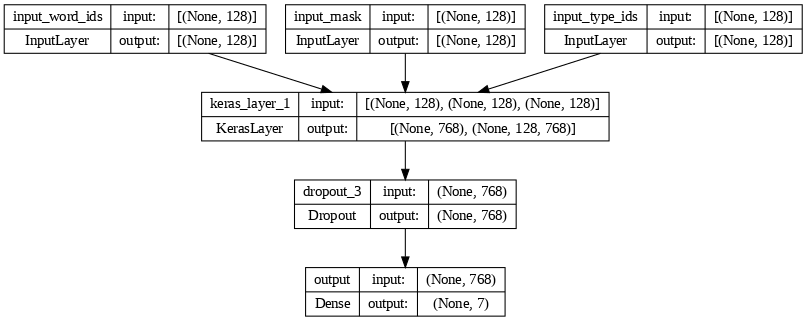

In [54]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [29]:
from sklearn.utils.class_weight import compute_class_weight

**Class_Weights**

In [30]:
labels = new2_df['label_encoded'].values

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Create a dictionary of class weights
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 4.195368340798628, 1: 8.16734693877551, 2: 0.6949013417521704, 3: 8.114654377880184, 4: 1.4615052621094917, 5: 0.3565920357709879, 6: 0.6295782503611115}


In [31]:
train_data

<_PrefetchDataset element_spec=({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(32, 7), dtype=tf.int32, name=None))>

In [32]:
valid_data

<_PrefetchDataset element_spec=({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(32, 7), dtype=tf.int32, name=None))>

**TRAIN**

In [70]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    class_weight=class_weights_dict,
                    verbose=1)

Epoch 1/4


ValueError: ignored